In [1]:
import numpy as np
import pandas as pd
from rdkit import Chem
from rdkit.Chem import DataStructs, AllChem
from rdkit.Chem.MolStandardize import rdMolStandardize
from rdkit.Chem import Descriptors
from rdkit.ML.Descriptors import MoleculeDescriptors
from sklearn.model_selection import cross_val_score, train_test_split, cross_val_predict, KFold, GroupKFold
from sklearn import metrics
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
from catboost import CatBoostRegressor
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
#ILs for DESs dataset

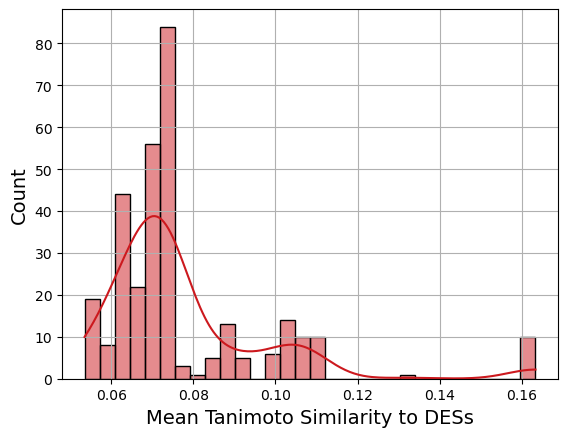

In [3]:
def compute_tanimoto(smiles1, smiles2):
    mols1 = [Chem.MolFromSmiles(sm) for sm in smiles1]
    mols2 = [Chem.MolFromSmiles(sm) for sm in smiles2]

    fps1 = [AllChem.GetMorganFingerprintAsBitVect(m, 2, nBits=2048) for m in mols1]
    fps2 = [AllChem.GetMorganFingerprintAsBitVect(m, 2, nBits=2048) for m in mols2]

    scores = []
    for fp in fps2: 
        similarities = [DataStructs.FingerprintSimilarity(fp, fp_ref) for fp_ref in fps1]
        scores.append(np.mean(similarities))  

    return scores

df_ils = pd.read_excel("Hx_ILs(cur).xlsx")
df_dess = pd.read_excel("Hx_DESs(cur).xlsx")


df_ils["Tanimoto_to_DESs"] = compute_tanimoto(df_dess["SMILES_DES"].dropna().tolist(), df_ils["SMILES_IL"].dropna().tolist())


sns.histplot(df_ils["Tanimoto_to_DESs"], bins=30, kde=True, color="#cc191e")
plt.xlabel("Mean Tanimoto Similarity to DESs", fontsize=14)
plt.ylabel("Count", fontsize=14)
plt.grid()
plt.show()

# Если ничего не выбрано, ослабляем порог
lower, upper = 0.2, 0.55  # Начальные границы
selected_ils = df_ils[(df_ils["Tanimoto_to_DESs"] >= lower) & (df_ils["Tanimoto_to_DESs"] <= upper)]

while selected_ils.empty and lower > 0.1:
    lower -= 0.1 
    upper += 0.1 
    selected_ils = df_ils[(df_ils["Tanimoto_to_DESs"] >= lower) & (df_ils["Tanimoto_to_DESs"] <= upper)]

In [5]:
#RDKit

In [6]:
def RDkit_descriptors(smiles):
    mols = [Chem.MolFromSmiles(i) for i in smiles] 
    calc = MoleculeDescriptors.MolecularDescriptorCalculator([x[0] for x in Descriptors._descList])
    desc_names = calc.GetDescriptorNames()
    
    Mol_descriptors =[]
    for mol in mols:
        
        mol=Chem.AddHs(mol)
        
        descriptors = calc.CalcDescriptors(mol)
        Mol_descriptors.append(descriptors)
    return Mol_descriptors,desc_names 

In [7]:
Mol_descriptors_HBA,desc_names = RDkit_descriptors(df_dess['SMILES_HBA'])
Mol_descriptors_HBD,desc_names = RDkit_descriptors(df_dess['SMILES_HBD'])

In [8]:
df_descriptors_HBA = pd.DataFrame(Mol_descriptors_HBA,columns=desc_names)
df_descriptors_HBD = pd.DataFrame(Mol_descriptors_HBD,columns=desc_names)

In [9]:
HBA = df_descriptors_HBA.multiply(df_dess['x_HBA'], axis=0)
HBD = df_descriptors_HBD.multiply(df_dess['x_HBD'], axis=0)

In [10]:
HBA = HBA.fillna(0)
HBD = HBD.fillna(0)

In [11]:
rdkit_result_des = (HBA + HBD) / 2

In [12]:
rdkit_result_f = rdkit_result_des.loc[:, ~np.isinf(rdkit_result_des).any()].loc[:, (rdkit_result_des != 0).any(axis=0)]
corr = rdkit_result_f.corr().applymap(lambda x: 0 if x == 1 else x)
list_desc_rdkit = corr[(corr <= 0.95)].dropna(how='all').index.tolist()
print('Number of descriptors rdkit:', len(list_desc_rdkit) - 1)

Number of descriptors rdkit: 146


In [13]:
des_rdkit_des = rdkit_result_des[list_desc_rdkit]

In [14]:
X_des = pd.concat([df_dess["T"], des_rdkit_des], axis=1)
y_des = df_dess["Hx-Exp Mpa"]

In [15]:
Mol_descriptors_HBA,desc_names = RDkit_descriptors(selected_ils['SMILES_IL'])
df_descriptors_ILs = pd.DataFrame(Mol_descriptors_HBA,columns=desc_names)
rdkit_result = df_descriptors_ILs.fillna(0)
des_rdkit_ils = rdkit_result[list_desc_rdkit]

In [16]:
selected_ils = selected_ils.reset_index()

In [17]:
X_ils = pd.concat([selected_ils["T (K)"], des_rdkit_ils], axis=1)
y_ils = selected_ils["Henry's Constant H (MPa)"]

In [18]:
X_ils.rename(columns={'T (K)': 'T'},  inplace=True)

In [19]:
X =pd.concat([X_des, X_ils], axis=0)
X = X.reset_index()

In [20]:
y = pd.concat([y_des, y_ils], axis=0, ignore_index=True)

In [21]:
#Random splitting

In [22]:
cv = KFold(n_splits=5, shuffle=True, random_state=42)

In [23]:
Y_pred, Y_true = [], []
r2_scores, rmse_scores, mae_scores, aards = [], [], [], []

for train_index, test_index in cv.split(X):
    x_train = X.loc[train_index].values
    x_test = X.loc[test_index].values
    y_train = y[train_index]
    y_test = y[test_index]
    
    rf = CatBoostRegressor(silent=True, iterations = 723, depth = 5, learning_rate = 0.1485591930008091, subsample = 0.6061157688448664)
    rf.fit(x_train, y_train)
    y_pred = rf.predict(x_test)
    
    Y_pred.extend(y_pred)
    Y_true.extend(y_test)
    
    r2_scores.append(metrics.r2_score(y_test, y_pred))
    rmse_scores.append(metrics.mean_squared_error(y_test, y_pred, squared=False))
    mae_scores.append(mean_absolute_error(y_test, y_pred))
    
    relative_deviation = (y_test - y_pred) / y_test
    absolute_relative_deviation = abs(relative_deviation)
    average_relative_deviation = absolute_relative_deviation.mean() * 100
    aards.append(average_relative_deviation)

print('R^2 = {} ± {}'.format(round(np.mean(r2_scores), 3), round(np.std(r2_scores), 3)))
print('RMSE = {} ± {}'.format(round(np.mean(rmse_scores), 3), round(np.std(rmse_scores), 3)))
print('MAE = {} ± {}'.format(round(np.mean(mae_scores), 3), round(np.std(mae_scores), 3)))
print('AARD = {} ± {}'.format(round(np.mean(aards), 3), round(np.std(aards), 3)))

R^2 = 0.933 ± 0.042
RMSE = 3.292 ± 0.798
MAE = 1.844 ± 0.239
AARD = 10.366 ± 2.118


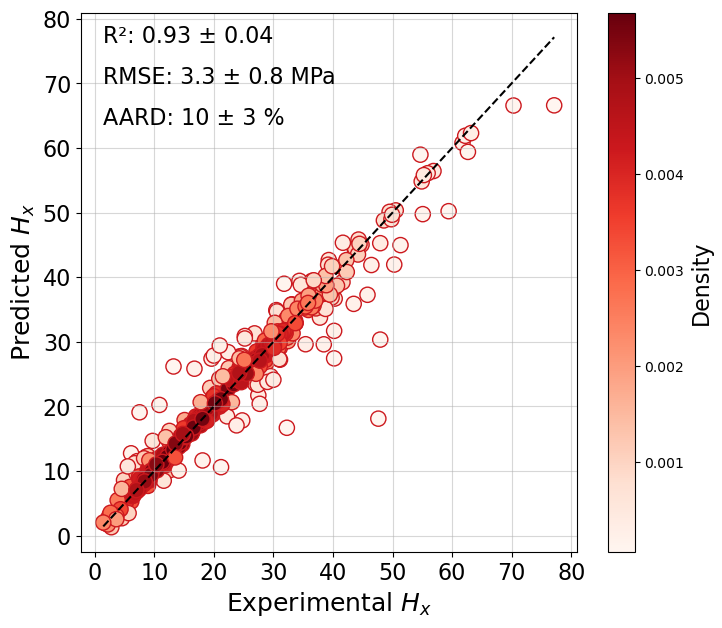

In [24]:
from scipy.stats import gaussian_kde

experimental = np.array(Y_true)
predicted = np.array(Y_pred) 
errors = predicted - experimental

def calculate_aard(experimental, predicted):
    relative_errors = np.abs((experimental - predicted) / experimental)
    aard = np.mean(relative_errors) * 100  
    return aard

def scatter_density_plot(experimental, predicted):
    
    xy = np.vstack([experimental, predicted])
    z = gaussian_kde(xy)(xy)
   
    plt.figure(figsize=(8, 7))
   
    plt.subplot(1, 1, 1)
    scatter = plt.scatter(experimental, predicted, c=z, s=120, cmap='Reds', alpha=1, edgecolor='#cc191e')
    cbar = plt.colorbar(scatter)
    cbar.set_label('Density', fontsize=16)
    plt.yticks(fontsize=16)
    plt.xticks(fontsize=16)
    
    plt.plot([min(experimental), max(experimental)], [min(experimental), max(experimental)], 'k--')
    plt.xlabel(r'Experimental $H_x$', fontsize=18)
    plt.ylabel(r'Predicted $H_x$', fontsize=18)
    plt.grid(True, alpha=0.5)

    plt.text(min(experimental), max(predicted) - 3, f'R²: 0.93 ± 0.04 \nRMSE: 3.3 ± 0.8 MPa \nAARD: 10 ± 3 %', fontsize=16, linespacing=2)

scatter_density_plot(experimental, predicted)

In [25]:
#Strict splitting

In [26]:
class UniqueGroupKFold:
    def __init__(self, n_splits=5, shuffle=False, random_state=None):
        self.n_splits = n_splits
        self.shuffle = shuffle
        self.random_state = random_state

    def get_n_splits(self, X=None, y=None, groups=None):
        return self.n_splits

    def split(self, X, y=None, groups=None):
        unique_groups = np.unique(groups)
        if self.shuffle:
            np.random.seed(self.random_state)
            np.random.shuffle(unique_groups)
        
        fold_size = len(unique_groups) // self.n_splits
        
        for i in range(self.n_splits):
            if i == self.n_splits - 1:
                test_groups = unique_groups[i * fold_size:]
            else:
                test_groups = unique_groups[i * fold_size: (i + 1) * fold_size]
            
            test_indices = np.where(np.isin(groups, test_groups))[0]
            train_indices = np.where(~np.isin(groups, test_groups))[0]
            
            if len(test_indices) > 0 and len(train_indices) > 0:
                yield train_indices, test_indices

In [27]:
cv = UniqueGroupKFold(n_splits=5, shuffle=True, random_state=42)

In [28]:
s =pd.concat([df_dess["SMILES_DES"], selected_ils["SMILES_IL"]], axis=0, ignore_index=True)

In [29]:
Y_pred, Y_true = [], []
r2_scores, rmse_scores, mae_scores, aards = [], [], [], []

for train_index, test_index in cv.split(X, groups=s):
    x_train = X.loc[train_index].values
    x_test = X.loc[test_index].values
    y_train = y[train_index]
    y_test = y[test_index]
    
    rf = CatBoostRegressor(silent=True)
    rf.fit(x_train, y_train)
    y_pred = rf.predict(x_test)

    Y_pred.extend(y_pred)
    Y_true.extend(y_test)

    r2_scores.append(metrics.r2_score(y_test, y_pred))
    rmse_scores.append(metrics.mean_squared_error(y_test, y_pred, squared=False))
    mae_scores.append(mean_absolute_error(y_test, y_pred))

    relative_deviation = (y_test - y_pred) / y_test
    absolute_relative_deviation = abs(relative_deviation)
    average_relative_deviation = absolute_relative_deviation.mean() * 100
    aards.append(average_relative_deviation)

print('R^2 = {} ± {}'.format(round(np.mean(r2_scores), 3), round(np.std(r2_scores), 3)))
print('RMSE = {} ± {}'.format(round(np.mean(rmse_scores), 3), round(np.std(rmse_scores), 3)))
print('MAE = {} ± {}'.format(round(np.mean(mae_scores), 3), round(np.std(mae_scores), 3)))
print('AARD = {} ± {}'.format(round(np.mean(aards), 3), round(np.std(aards), 3)))


R^2 = 0.685 ± 0.083
RMSE = 7.423 ± 2.331
MAE = 5.299 ± 1.193
AARD = 33.81 ± 10.389


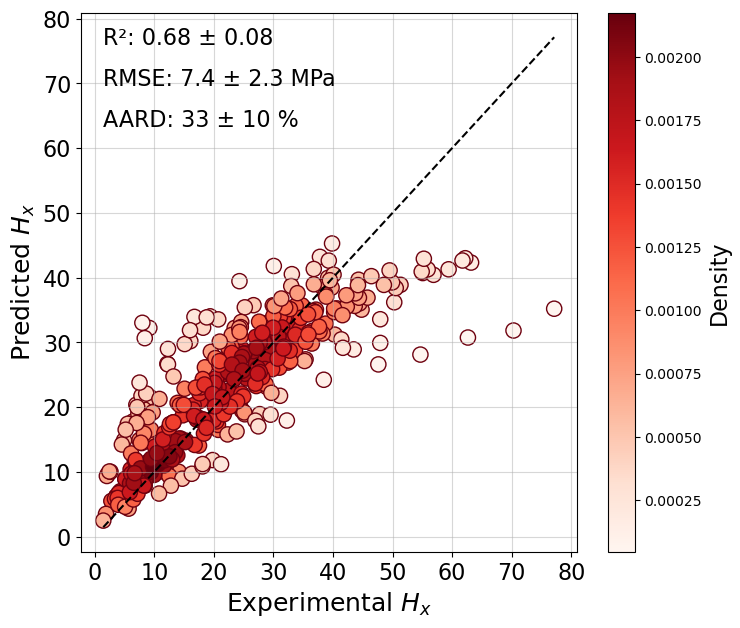

In [30]:
from scipy.stats import gaussian_kde

experimental = np.array(Y_true) 
predicted = np.array(Y_pred) 

errors = predicted - experimental

def calculate_aard(experimental, predicted):
    relative_errors = np.abs((experimental - predicted) / experimental)
    aard = np.mean(relative_errors) * 100  # В процентах
    return aard

# Функция для построения диаграммы рассеяния с плотностью
def scatter_density_plot(experimental, predicted):
    # Рассчет плотности точек
    xy = np.vstack([experimental, predicted])
    z = gaussian_kde(xy)(xy)

    # Построение графика
    plt.figure(figsize=(8, 7))

    # Левый график (scatter plot)
    plt.subplot(1, 1, 1)
    scatter = plt.scatter(experimental, predicted, c=z, s=120, cmap='Reds', alpha=1, edgecolor='#6e010f')
    cbar = plt.colorbar(scatter)
    cbar.set_label('Density', fontsize=16)
    
    plt.yticks(fontsize=16)
    plt.xticks(fontsize=16)


    plt.plot([min(experimental), max(experimental)], [min(experimental), max(experimental)], 'k--')

    plt.xlabel(r'Experimental $H_x$', fontsize=18)
    plt.ylabel(r'Predicted $H_x$', fontsize=18)
    plt.grid(True, alpha=0.5)

    plt.text(min(experimental), max(predicted) + 18, f'R²: 0.68 ± 0.08 \nRMSE: 7.4 ± 2.3 MPa \nAARD: 33 ± 10 %', fontsize=16, linespacing=2)

scatter_density_plot(experimental, predicted)

In [31]:
#Applicability Domain

In [32]:
import shap

In [33]:
n_samples = X.shape[0]

In [34]:
all_leverages = np.zeros(n_samples)
all_residuals = np.zeros(n_samples)

In [35]:
X=X.values

In [36]:
for fold, (train_idx, test_idx) in enumerate(cv.split(X, groups=s)):
    print(f'fold {fold+1}/5...')
    X_train, X_test = X[train_idx], X[test_idx]
    y_train, y_test = y[train_idx], y[test_idx]
    

    model = CatBoostRegressor(silent=True)
    model.fit(X_train, y_train)
    

    explainer = shap.TreeExplainer(model)
    shap_values = explainer.shap_values(X_test)
    

    shap_matrix = np.abs(shap_values)
    leverage_shap = shap_matrix.sum(axis=1)  
    

    y_pred = model.predict(X_test)
    residuals = y_test - y_pred
    std_residuals = residuals / np.std(residuals)
    

    all_leverages[test_idx] = leverage_shap 
    all_residuals[test_idx] = std_residuals 

fold 1/5...
fold 2/5...
fold 3/5...
fold 4/5...
fold 5/5...


In [37]:
h_star = np.percentile(all_leverages, 95)
out_of_leverage = np.sum(all_leverages > h_star)
out_of_residuals = np.sum((all_residuals < -3) | (all_residuals > 3))

print(f'Number of points outside the SHAP lever threshold (L*): {out_of_leverage}')
print(f'Number of points outside the boundaries of standardized residuals (±3): {out_of_residuals}')

Number of points outside the SHAP lever threshold (L*): 20
Number of points outside the boundaries of standardized residuals (±3): 3


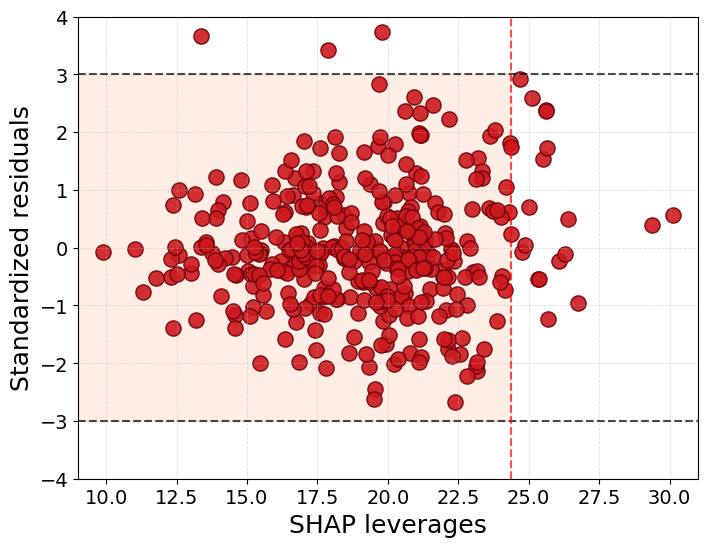

In [38]:
plt.figure(figsize=(8, 6))

plt.fill_between(
    x=[0, h_star], 
    y1=-3, 
    y2=3, 
    color='#fed2bf', 
    alpha=0.4  
)
plt.scatter(
    all_leverages, 
    all_residuals, 
    s=120, 
    color='#cc191e', 
    edgecolors='#6b010b', 
    linewidth=1, 
    alpha=0.9
)
plt.axhline(y=3, color='black', linestyle='--', alpha=0.7)
plt.axhline(y=-3, color='black', linestyle='--', alpha=0.7)
plt.axvline(x=h_star, color='red', linestyle='--', alpha=0.7)
plt.xlabel('SHAP leverages',fontsize=18)
plt.ylabel('Standardized residuals', fontsize=18)

plt.grid(True, linestyle='--', linewidth=0.6, alpha=0.4)
plt.xlim(9, 31) 
plt.ylim(-4, 4) 
plt.yticks(fontsize=14)
plt.xticks(fontsize=14)
plt.show()